# Convolution Layer 와 Pooling Layer의 역할

간단한 예제를 통하여 convolutional layer 와 pooling layer의 역할을 확인해 본다.

**Convolutional Layer**
* Convolutional layer는 입력 데이터로 부터 특징을 추출하는 역할을 한다.
* 필터는 그 특징이 데이타에 있는지 없는지를 검출하는 역할을 한다.
* 필터가 바로 Conv Layer의 가중치에 해당한다.
* 이미지에 필터를 적용해서 얻어낸 결과를 Feature map 또는 activation map 이라고 한다.
* Stride : 필터가 이동할 간격을 말한다.
* padding :  필터를 적용한 후의 결과값은 필터 적용전 보다 작아진다. 이를 방지하기 위해서 입력값 주위로 0 값을 넣어 준다.

**Pooling Layer**
* convolutional layer를 거쳐서 추출된 특징들은 필요에 따라서 서브 샘플링 (sub sampling)이라는 과정을 거친다.
* 추출된 Activation map을 차원을 축소하는 작업을 하는데, 이 작업을 sub sampling 또는 pooling 이라고 한다.
* 전체 데이타의 사이즈가 줄어들기 때문에 연산량을 줄일 수 있다.

### ConvNet 구조

위에서 컨볼루셔널 신경망은 일반적으로 CONV, POOL (별다른 언급이 없다면 Max Pool이라고 가정), FC 레이어로 이뤄져 있다는 것을 배웠다. 각 원소에 비선형 특징을 가해주는 RELU 액티베이션 함수도 명시적으로 레이어로 취급하겠다. 이 섹션에서는 어떤 방식으로 이 레이어들이 쌓아져 전체 ConvNet이 이뤄지는지 알아보겠다.

레이어 패턴 가장 흔한 ConvNet 구조는 몇 개의 CONV-RELU 레이어를 쌓은 뒤 POOL 레이어를 추가한 형태가 여러 번 반복되며 이미지 볼륨의 spatial (가로/세로) 크기를 줄이는 것이다. 이런 방식으로 적절히 쌓은 뒤 FC 레이어들을 쌓아준다. 마지막 FC 레이어는 클래스 점수와 같은 출력을 만들어낸다. 다시 말해서, 일반적인 ConvNet 구조는 다음 패턴을 따른다: 

> ` INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC `

*는 반복을 의미하며 POOL? 은 선택적으로 POOL 레이어를 사용한다는 의미이다. 또한 N >= 0 (보통 N <= 3), M >= 0, K >= 0 (보통 K < 3)이다. 예를 들어, 보통의 ConvNet 구조에서 아래와 같은 패턴들을 흔히 발견할 수 있다:

* INPUT -> FC, 선형 분류기이다. 이 때 N = M = K = 0.
* INPUT -> CONV -> RELU -> FC
* INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. 이 경우는 POOL 레이어 하나 당 하나의 CONV 레이어가 존재한다.
* INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC 이 경우는 각각의 POOL 레이어를 거치기 전에 여러 개의 CONV 레이어를 거치게 된다. 크고 깊은 신경망에서는 이런 구조가 적합하다. 여러 층으로 쌓인 CONV 레이어는 pooling 연산으로 인해 많은 정보가 파괴되기 전에 복잡한 feature들을 추출할 수 있게 해주기 때문이다.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

MNIST 데이터셋을 예제로 활용한다.

In [2]:
# Define a transform to normalize the data
transform = transforms.ToTensor()

# Download and load the training data
trainset = datasets.MNIST('../data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

C:\Users\aoneko\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


MNIST 데이터셋의 일부를 화면에 출력한다.

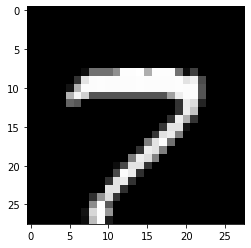

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

### Convoltional Layer

참고) https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html

Pytorch의 torch.nn.Conv2d로 convoltional layer를 구성한다.

```
torch.nn.Conv2d(in_channel, out_channel, kernel_size, stride=1, padding=0)
```

In [4]:
model = nn.Sequential(nn.Conv2d(1,1,3))
print(model)

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
)


### featured map

이미지를 convolutional layer에 적용하면 featured map을 결과로 확인할 수 있다.

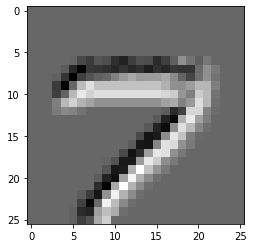

In [5]:
# featured map 을 화면에 출력해 본다.
featured_map = model(images[0].unsqueeze(0))
plt.imshow(featured_map.data.numpy().squeeze(), cmap='gray');

### filter
convolution에 적용된 filter 는 convolutional layer의 가중치이다.  
적용된 filter를 화면에 출력해 본다.

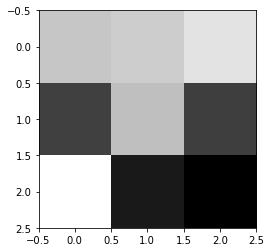

In [6]:
weight = model.state_dict()['0.weight']
plt.imshow(weight.squeeze(), cmap='gray')

Convolutional layer는 input image에 해당 필터를 적용하여 featured map이 생성된다.

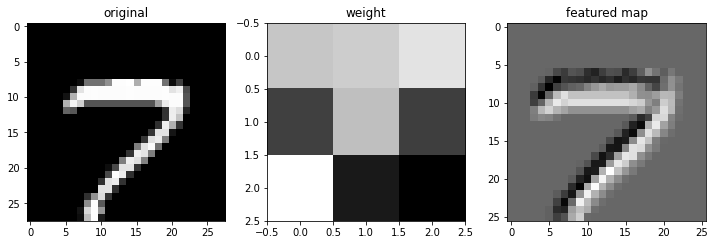

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title('original')
plt.imshow(images[0].numpy().squeeze(), cmap='gray');
plt.subplot(1,3,2)
plt.imshow(weight.data.numpy().squeeze(), cmap='gray')
plt.title('weight')
plt.subplot(1,3,3)
plt.imshow(featured_map.data.numpy().squeeze(), cmap='gray')
plt.title('featured map')

plt.tight_layout()

### 활성화 함수 - ReLU

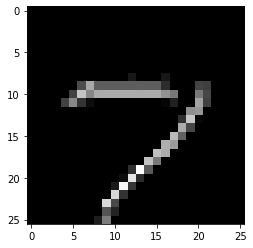

In [8]:
relu = F.relu(featured_map)
plt.imshow(relu.data.squeeze().numpy(), cmap='gray')

### Max Pooling Layer
추출된 특징들은 필요에 따라서 서브 샘플링 (sub sampling)이라는 과정을 커쳐 차원을 축소한다. 이를 통해 계산량을 줄이고 좀 더 뚜렷한 특징 feature를 보존하게 한다.

C:\Users\aoneko\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


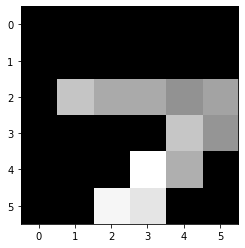

In [9]:
maxpool= nn.MaxPool2d(4,4)
plt.imshow(maxpool(relu).data.squeeze().numpy(), cmap='gray')